# Storage Story: Exploratory Analysis of Personal Media Storage Metadata
**Personal Media Storage Metadata**

**Framework:** Google Data Analytics Capstone (Ask, Prepare, Process, Analyze, Share, Act)

**Author:** Hans Darmawan  
**Language:** Python  
**Analysis Type:** Exploratory Data Analysis (EDA)

---

## Project Context

This case study applies exploratory data analysis (EDA) to **anonymized personal media storage metadata** generated from photography and videography activities. As media files accumulate over time, storage usage increases rapidly, making it increasingly difficult to plan storage capacity and manage archives efficiently.

Using the **Google Data Analytics Capstone framework**, this analysis focuses on understanding **how storage is consumed**, **which file types contribute most to storage growth**, and **how shooting behavior changes over time**. The objective is to transform raw file-level metadata into clear, actionable insights that support better storage planning and long-term archive management.


## Business Task Summary

The purpose of this analysis is to explore and understand the dataset in order to identify meaningful patterns, data quality issues, and insights that can support informed decision-making. This project follows the Google Data Analytics Capstone framework and focuses on insight generation rather than predictive modeling.

## 0. Setup & Environment

This section initializes the Python environment and libraries used throughout the analysis.

In [166]:
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import squarify

# Pandas display configuration
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

# Visualization style
sns.set_theme(style="whitegrid")

# Project paths
BASE_DIR = Path("..")
DATASETS_DIR = BASE_DIR / "datasets"
FIGURES_DIR = BASE_DIR / "figures"

DATASETS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Dataset files
FILES_CLEAN_ENGINEERED_CSV = DATASETS_DIR / "files_clean_engineered.csv"

## 1. Ask

### 1.1 Business Question
What patterns, trends, and data quality considerations exist within the dataset, and how can these insights support future analysis or business decisions?

### 1.2 Stakeholders
- Data analysts and data scientists
- Business decision-makers
- Project reviewers or external audiences

### 1.3 Success Criteria
- Clear understanding of dataset structure and limitations
- Actionable insights supported by evidence
- Transparent and reproducible analysis

## 2. Prepare

This phase focuses on understanding the data source, structure, and overall reliability.

In [167]:
DATA_PATH = "../datasets/files.csv"

df = pd.read_csv(DATA_PATH, sep=";")

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109543 entries, 0 to 109542
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   albumRootId       109543 non-null  int64 
 1   albumId           109543 non-null  int64 
 2   imageId           109543 non-null  int64 
 3   fileCategory      109543 non-null  int64 
 4   fileCategoryName  109543 non-null  object
 5   fileSize          109543 non-null  int64 
 6   fileDate          109543 non-null  object
 7   format            109543 non-null  object
dtypes: int64(5), object(3)
memory usage: 6.7+ MB


,albumRootId,albumId,imageId,fileCategory,fileCategoryName,fileSize,fileDate,format
0,2,5,1,3,Audio,3614976,2008-01-27,M4A
1,2,5,2,3,Audio,4230677,2008-01-27,M4A
2,2,5,3,3,Audio,3454637,2008-01-27,M4A
3,2,5,4,3,Audio,3152782,2008-01-27,M4A
4,2,5,5,3,Audio,3413493,2008-01-27,M4A


### Data Quality Overview

This table summarizes column-level completeness and data types.

In [168]:
summary_df = pd.DataFrame(
    {
        "column": df.columns,
        "data_type": df.dtypes.astype(str),
        "non_null_count": df.notna().sum(),
        "missing_percentage": (df.isna().mean() * 100).round(2),
    }
)

summary_df

,column,data_type,non_null_count,missing_percentage
albumRootId,albumRootId,int64,109543,0.0
albumId,albumId,int64,109543,0.0
imageId,imageId,int64,109543,0.0
fileCategory,fileCategory,int64,109543,0.0
fileCategoryName,fileCategoryName,object,109543,0.0
fileSize,fileSize,int64,109543,0.0
fileDate,fileDate,object,109543,0.0
format,format,object,109543,0.0


## 3. Process

This phase documents how the data is cleaned and prepared for analysis.

In [169]:
missing_counts = df.isnull().sum()

missing_counts

albumRootId         0
albumId             0
imageId             0
fileCategory        0
fileCategoryName    0
fileSize            0
fileDate            0
format              0
dtype: int64

In [170]:
duplicated_counts = df.duplicated().sum()

duplicated_counts

np.int64(0)

In [171]:
# Create a working copy to preserve the raw dataset
df_clean = df.copy()

Cleaning decisions are intentionally minimal and fully documented to preserve data integrity.

## 4. Analyze

This phase explores patterns, distributions, and relationships within the dataset.

In [172]:
numeric_summary = df_clean.describe().T

numeric_summary

,count,mean,std,min,25%,50%,75%,max
albumRootId,109543.0,2.848763e+00,1.306715e+00,2.0,2.0,2.0,3.0,7.000000e+00
albumId,109543.0,3.912567e+03,3.120768e+03,5.0,880.0,2977.0,6986.0,9.019000e+03
imageId,109543.0,5.478113e+04,3.163348e+04,1.0,27386.5,54772.0,82187.5,1.095730e+05
fileCategory,109543.0,1.093215e+00,2.948807e-01,1.0,1.0,1.0,1.0,3.000000e+00
fileSize,109543.0,1.632571e+07,1.200061e+08,3841.0,2107197.0,4776568.0,7716065.0,7.259500e+09


In [173]:
# parse yyyy-mm-dd into datetime
df_clean["fileDate"] = pd.to_datetime(
    df_clean["fileDate"],
    format="%Y-%m-%d",
    errors="coerce"
)

# derive date components
df_clean["year"] = df_clean["fileDate"].dt.year
df_clean["month"] = df_clean["fileDate"].dt.month
df_clean["month_name"] = df_clean["fileDate"].dt.month_name()
df_clean["day_of_week"] = df_clean["fileDate"].dt.day_name()
df_clean["day"] = df_clean["fileDate"].dt.day

df_clean.head()


,albumRootId,albumId,imageId,fileCategory,fileCategoryName,fileSize,fileDate,format,year,month,month_name,day_of_week,day
0,2,5,1,3,Audio,3614976,2008-01-27,M4A,2008,1,January,Sunday,27
1,2,5,2,3,Audio,4230677,2008-01-27,M4A,2008,1,January,Sunday,27
2,2,5,3,3,Audio,3454637,2008-01-27,M4A,2008,1,January,Sunday,27
3,2,5,4,3,Audio,3152782,2008-01-27,M4A,2008,1,January,Sunday,27
4,2,5,5,3,Audio,3413493,2008-01-27,M4A,2008,1,January,Sunday,27


In [174]:
# convert file size from bytes
df_clean["file_size_mb"] = df_clean["fileSize"] / (1024 ** 2)
df_clean["file_size_gb"] = df_clean["fileSize"] / (1024 ** 3)

# round values
df_clean["file_size_mb"] = df_clean["file_size_mb"].round(2)
df_clean["file_size_gb"] = df_clean["file_size_gb"].round(4)

df_clean.head()

,albumRootId,albumId,imageId,fileCategory,fileCategoryName,fileSize,fileDate,format,year,month,month_name,day_of_week,day,file_size_mb,file_size_gb
0,2,5,1,3,Audio,3614976,2008-01-27,M4A,2008,1,January,Sunday,27,3.45,0.0034
1,2,5,2,3,Audio,4230677,2008-01-27,M4A,2008,1,January,Sunday,27,4.03,0.0039
2,2,5,3,3,Audio,3454637,2008-01-27,M4A,2008,1,January,Sunday,27,3.29,0.0032
3,2,5,4,3,Audio,3152782,2008-01-27,M4A,2008,1,January,Sunday,27,3.01,0.0029
4,2,5,5,3,Audio,3413493,2008-01-27,M4A,2008,1,January,Sunday,27,3.26,0.0032


In [175]:
def plot_category_count_pie(df):
    agg_df = (
        df.groupby("fileCategoryName")
        .size()
        .reset_index(name="file_count")
        .sort_values("file_count", ascending=False)
    )

    plt.figure(figsize=(7, 7))

    plt.pie(
        agg_df["file_count"],
        labels=agg_df["fileCategoryName"],
        autopct="%1.1f%%",
        startangle=90,
        counterclock=False,
        wedgeprops={"edgecolor": "white"},
        textprops={"fontsize": 12},
    )

    plt.title("File Count Distribution by Category", fontsize=14)
    plt.tight_layout()
    plt.show()

In [176]:
def plot_category_size_pie(df):
    agg_df = (
        df.groupby("fileCategoryName", as_index=False)["fileSize"]
        .sum()
        .assign(total_gb=lambda x: x["fileSize"] / (1024 ** 3))
        .sort_values("total_gb", ascending=False)
    )

    plt.figure(figsize=(7, 7))

    plt.pie(
        agg_df["total_gb"],
        labels=agg_df["fileCategoryName"],
        autopct="%1.1f%%",
        startangle=90,
        counterclock=False,
        wedgeprops={"edgecolor": "white"},
        textprops={"fontsize": 12},
    )

    plt.title("Storage Distribution by Category", fontsize=14)
    plt.tight_layout()
    plt.show()

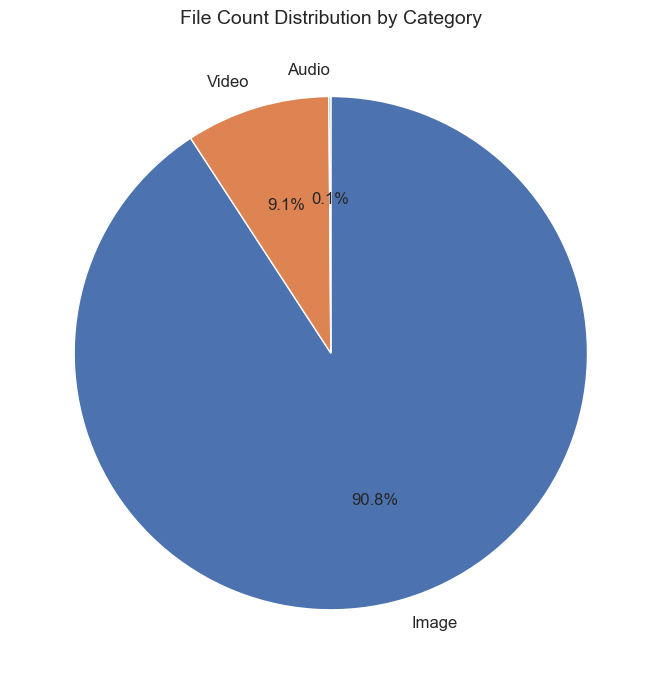

In [177]:
plot_category_count_pie(df_clean)

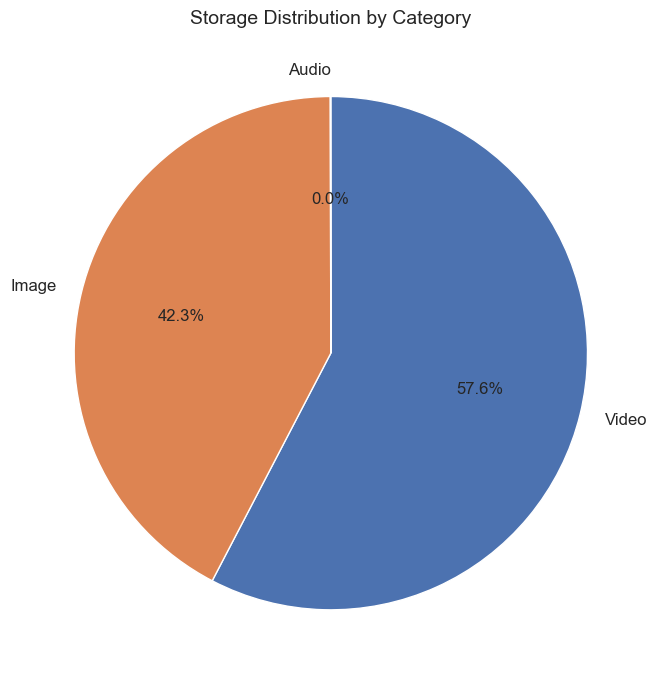

In [178]:
plot_category_size_pie(df_clean)

In [179]:
def plot_count(
    df: pd.DataFrame,
    column: str,
    top_n: int = 10,
    title: Optional[str] = None,
) -> None:
    """
    Plot the frequency distribution of a categorical column and save the figure.
    """
    FIGURES_DIR.mkdir(parents=True, exist_ok=True)

    plt.figure(figsize=(12, 7))

    temp_df = df.copy()
    temp_df[column] = temp_df[column].astype(str)

    total_count = len(temp_df)
    counts = temp_df[column].value_counts().head(top_n)
    order = counts.index

    max_val = counts.max()
    min_val = counts.min()

    description = (
        f"Frequency Distribution of "
        f"{column.replace('_', ' ').title()} (Top {top_n})"
    )

    ax = sns.countplot(
        data=temp_df[temp_df[column].isin(order)],
        y=column,
        order=order,
        hue=column,
        palette="viridis",
        legend=False,
    )

    for patch in ax.patches:
        width = patch.get_width()
        percentage = 100 * width / total_count
        label = f"{int(width):,} ({percentage:.1f}%)"

        if width == max_val:
            text_color = "green"
            font_weight = "bold"
        elif width == min_val:
            text_color = "red"
            font_weight = "bold"
        else:
            text_color = "black"
            font_weight = "normal"

        ax.annotate(
            label,
            (width, patch.get_y() + patch.get_height() / 2),
            ha="left",
            va="center",
            xytext=(5, 0),
            textcoords="offset points",
            color=text_color,
            fontweight=font_weight,
        )

    ax.set_title(title or description, fontsize=14, pad=20)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])

    sns.despine(left=True, bottom=True)

    filename = description.replace(" ", "_").lower() + ".png"
    plt.savefig(FIGURES_DIR / filename, bbox_inches="tight", dpi=300)
    plt.show()

In [180]:
def plot_sum(
    df: pd.DataFrame,
    column: str,
    value_col: str = "file_size_mb",
    top_n: int = 10,
    title: Optional[str] = None,
) -> None:
    """
    Plot the total aggregated value of a column and save the figure.
    """
    FIGURES_DIR.mkdir(parents=True, exist_ok=True)

    plt.figure(figsize=(14, 7))

    sum_df = (
        df.groupby(column, as_index=False)[value_col]
        .sum()
        .sort_values(value_col, ascending=False)
        .head(top_n)
    )

    sum_df[column] = sum_df[column].astype(str)

    total_value = sum_df[value_col].sum()
    max_val = sum_df[value_col].max()
    min_val = sum_df[value_col].min()

    description = (
        f"Total {value_col.replace('_', ' ').title()} of "
        f"{column.replace('_', ' ').title()} (Top {top_n})"
    )

    ax = sns.barplot(
        data=sum_df,
        x=value_col,
        y=column,
        hue=column,
        palette="magma",
        legend=False,
    )

    # ------------------------------------------------------------------
    # Annotate bars (value + percentage)
    # ------------------------------------------------------------------
    for patch in ax.patches:
        width = patch.get_width()
        percentage = 100 * width / total_value

        if width >= 1024:
            value_label = f"{width / 1024:.2f} GB"
        else:
            value_label = f"{width:.1f} MB"

        label = f"{value_label} ({percentage:.1f}%)"

        if width == max_val:
            text_color = "green"
            font_weight = "bold"
        elif width == min_val:
            text_color = "red"
            font_weight = "bold"
        else:
            text_color = "black"
            font_weight = "normal"

        ax.annotate(
            label,
            (width, patch.get_y() + patch.get_height() / 2),
            ha="left",
            va="center",
            xytext=(6, 0),
            textcoords="offset points",
            color=text_color,
            fontweight=font_weight,
        )

    ax.set_title(title or description, fontsize=14, pad=20)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])

    sns.despine(left=True, bottom=True)

    filename = description.replace(" ", "_").lower() + ".png"
    plt.savefig(FIGURES_DIR / filename, bbox_inches="tight", dpi=300)
    plt.show()


In [181]:
def get_top_n(df: pd.DataFrame, column: str, max_top_n: int = 10) -> int:
    """Return a safe top_n value based on unique category count."""
    return min(max_top_n, df[column].nunique())

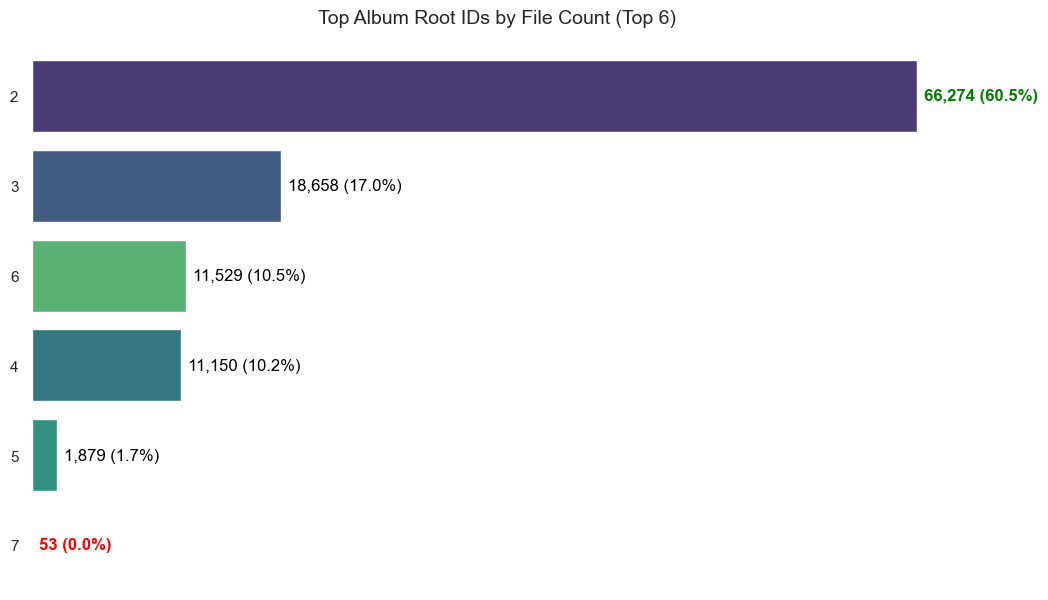

In [182]:
top_n = get_top_n(df_clean, "albumRootId")

plot_count(
    df=df_clean,
    column="albumRootId",
    top_n=top_n,
    title=f"Top Album Root IDs by File Count (Top {top_n})",
)

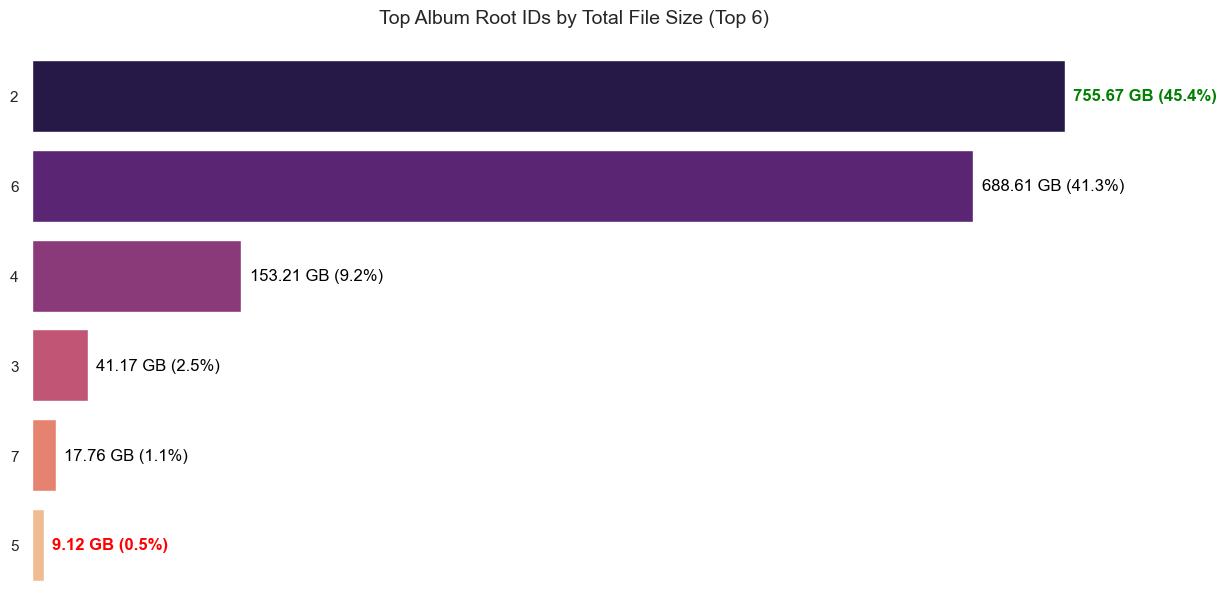

In [183]:
top_n = get_top_n(df_clean, "albumRootId")

plot_sum(
    df=df_clean,
    column="albumRootId",
    top_n=top_n,
    title=f"Top Album Root IDs by Total File Size (Top {top_n})",
)


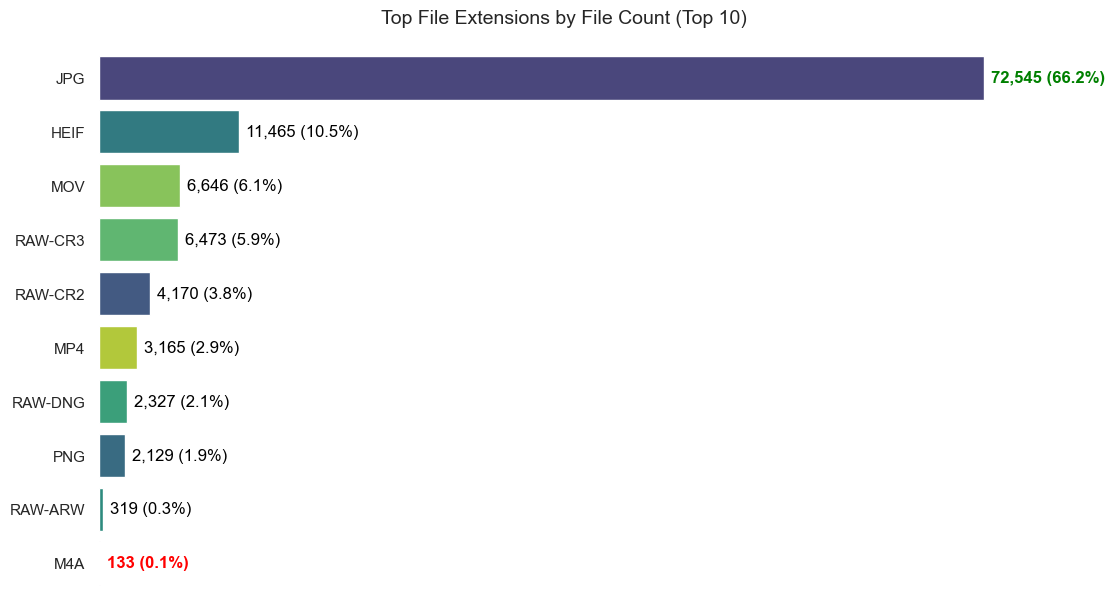

In [184]:
top_n = get_top_n(df_clean, "format")

plot_count(
    df=df_clean,
    column="format",
    top_n=top_n,
    title=f"Top File Extensions by File Count (Top {top_n})",
)


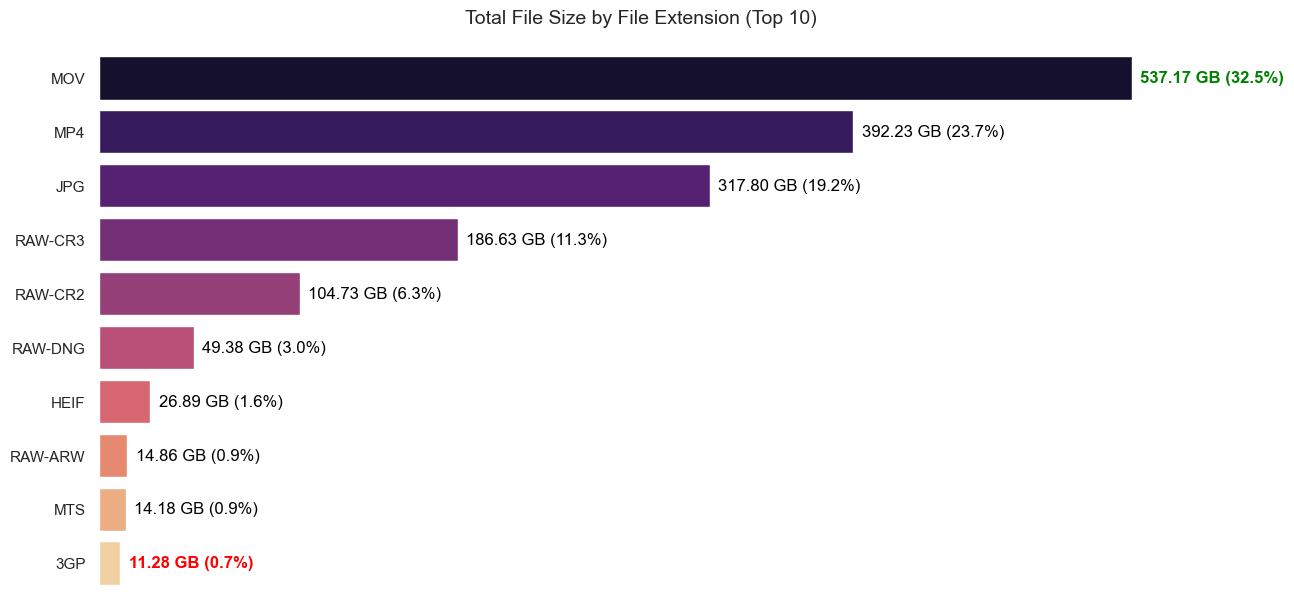

In [185]:
top_n = get_top_n(df_clean, "format")

plot_sum(
    df=df_clean,
    column="format",
    top_n=top_n,
    title=f"Total File Size by File Extension (Top {top_n})",
)


In [186]:
FIGURES_DIR = Path("../figures")


def plot_trend_count(
    df: pd.DataFrame,
    column: str = "year",
    title: Optional[str] = None,
) -> None:
    """
    Plot the trend of record counts over time with percentage progression
    and save the figure.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    column : str, default="year"
        Column representing the time axis.
    title : str, optional
        Custom plot title.
    """
    FIGURES_DIR.mkdir(parents=True, exist_ok=True)

    trend_df = (
        df.groupby(column)
        .size()
        .reset_index(name="file_count")
        .sort_values(column)
    )

    trend_df["progression"] = trend_df["file_count"].pct_change() * 100

    description = (
        f"Frequency Distribution of "
        f"{column.replace('_', ' ').title()} over Time"
    )

    plt.figure(figsize=(14, 8))

    ax = sns.lineplot(
        data=trend_df,
        x=column,
        y="file_count",
        marker="o",
        linewidth=2,
    )

    for _, row in trend_df.iterrows():
        x = row[column]
        y = row["file_count"]
        progression = row["progression"]

        ax.annotate(
            f"{int(y):,}",
            xy=(x, y),
            xytext=(0, 12),
            textcoords="offset points",
            ha="center",
            fontweight="bold",
        )

        if not pd.isna(progression):
            color = "green" if progression >= 0 else "red"
            sign = "+" if progression > 0 else ""

            ax.annotate(
                f"{sign}{progression:.1f}%",
                xy=(x, y),
                xytext=(0, -18),
                textcoords="offset points",
                ha="center",
                va="top",
                color=color,
                fontweight="bold",
            )

    ax.set_title(title or description, fontsize=14, pad=30)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks(trend_df[column].unique())

    sns.despine()

    filename = description.replace(" ", "_").lower() + ".png"
    output_path = FIGURES_DIR / filename

    plt.savefig(output_path, bbox_inches="tight", dpi=300)
    plt.show()

In [187]:
def plot_trend_sum(
    df: pd.DataFrame,
    column: str = "year",
    value_col: str = "fileSize",
    title: Optional[str] = None,
) -> None:
    """
    Plot the trend of total file size over time with percentage progression
    and save the figure.
    """
    assert column in df.columns, f"Column '{column}' not found in DataFrame"
    assert value_col in df.columns, f"Column '{value_col}' not found in DataFrame"

    FIGURES_DIR.mkdir(parents=True, exist_ok=True)

    trend_df = (
        df.groupby(column, as_index=False)[value_col]
        .sum()
        .assign(total_gb=lambda x: x[value_col] / (1024 ** 3))
        .sort_values(column)
    )

    trend_df["progression"] = trend_df["total_gb"].pct_change() * 100

    description = (
        f"Total File Size of "
        f"{column.replace('_', ' ').title()} over Time"
    )

    plt.figure(figsize=(14, 8))

    ax = sns.lineplot(
        data=trend_df,
        x=column,
        y="total_gb",
        marker="o",
        linewidth=2,
    )

    for _, row in trend_df.iterrows():
        x = row[column]
        y = row["total_gb"]
        progression = row["progression"]

        ax.annotate(
            f"{y:.2f} GB",
            xy=(x, y),
            xytext=(0, 12),
            textcoords="offset points",
            ha="center",
            fontweight="bold",
        )

        if not pd.isna(progression):
            color = "green" if progression >= 0 else "red"
            sign = "+" if progression > 0 else ""

            ax.annotate(
                f"{sign}{progression:.1f}%",
                xy=(x, y),
                xytext=(0, -18),
                textcoords="offset points",
                ha="center",
                va="top",
                color=color,
                fontweight="bold",
            )

    ax.set_title(title or description, fontsize=14, pad=30)
    ax.set_xlabel("")
    ax.set_ylabel("Total Size (GB)")
    ax.set_xticks(trend_df[column].unique())

    sns.despine()

    filename = description.replace(" ", "_").lower() + ".png"
    output_path = FIGURES_DIR / filename

    plt.savefig(output_path, bbox_inches="tight", dpi=300)
    plt.show()


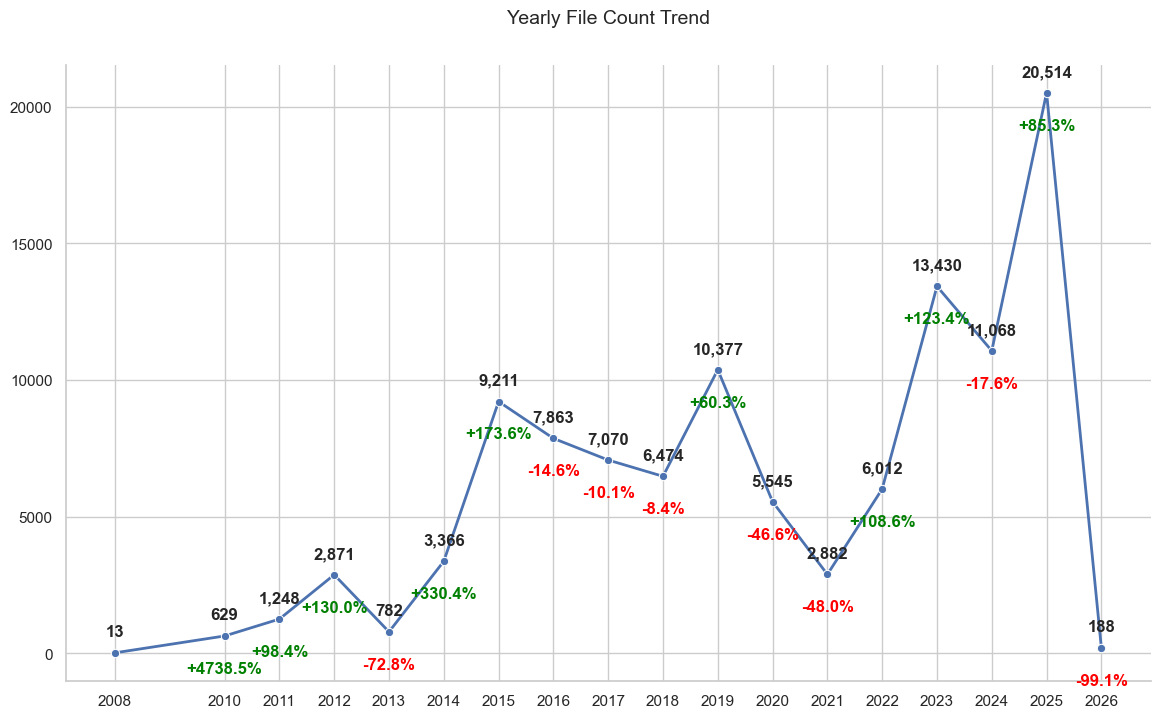

In [188]:
plot_trend_count(
    df=df_clean,
    column="year",
    title="Yearly File Count Trend",
)

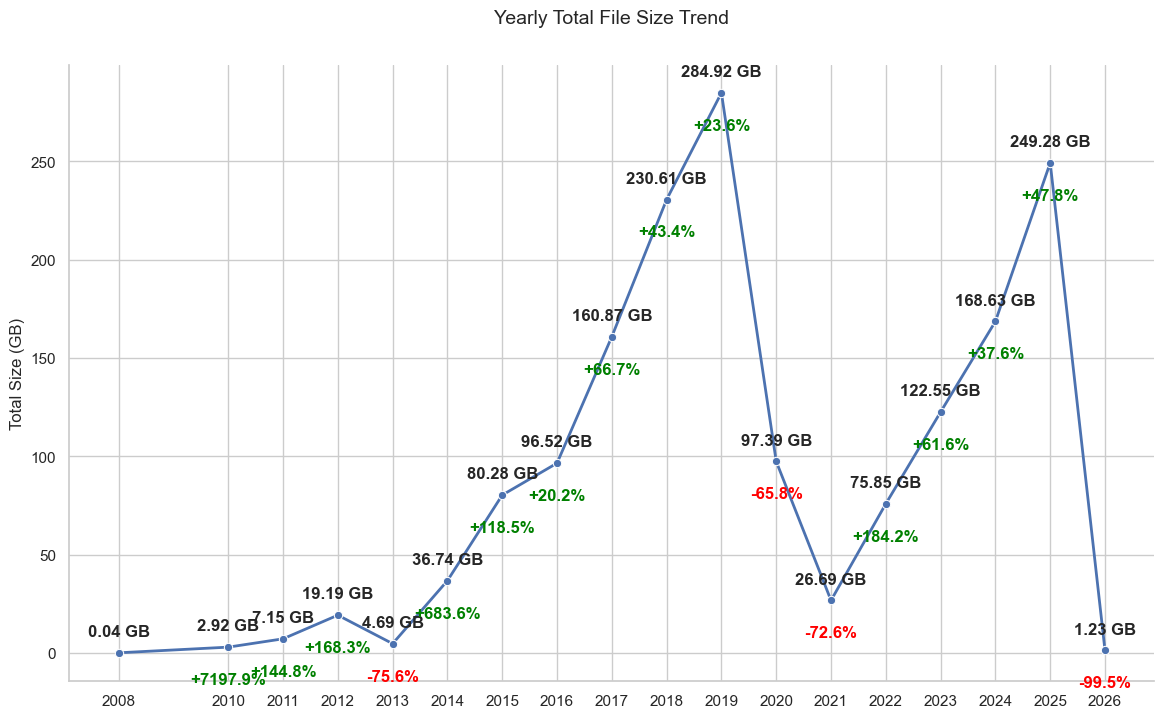

In [189]:
plot_trend_sum(
    df=df_clean,
    column="year",
    title="Yearly Total File Size Trend",
)

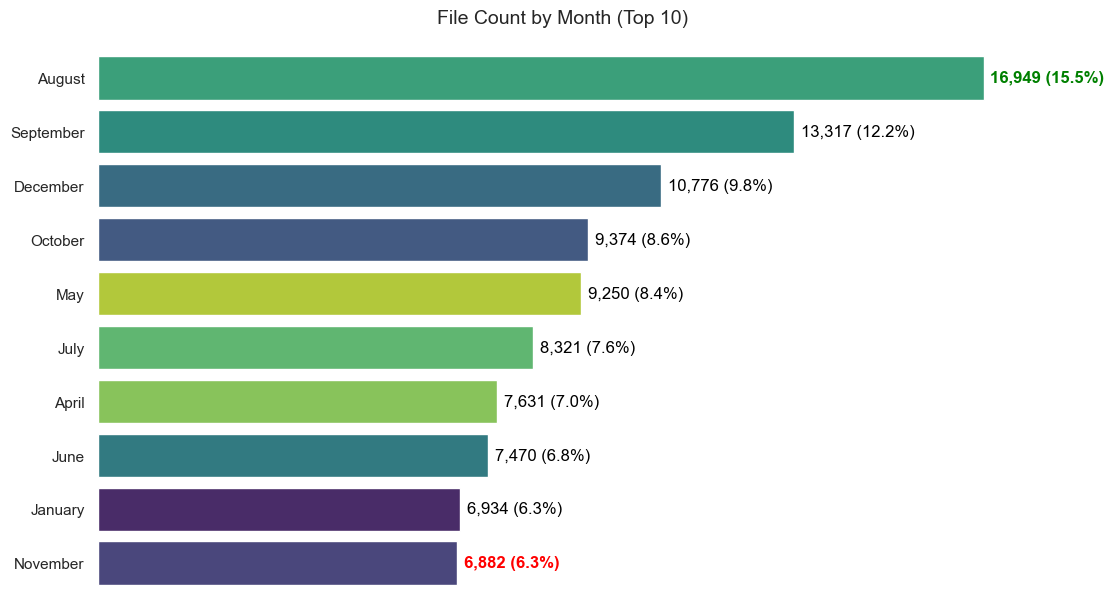

In [190]:
top_n = get_top_n(df_clean, "month_name")

plot_count(
    df=df_clean,
    column="month_name",
    top_n=top_n,
    title=f"File Count by Month (Top {top_n})",
)

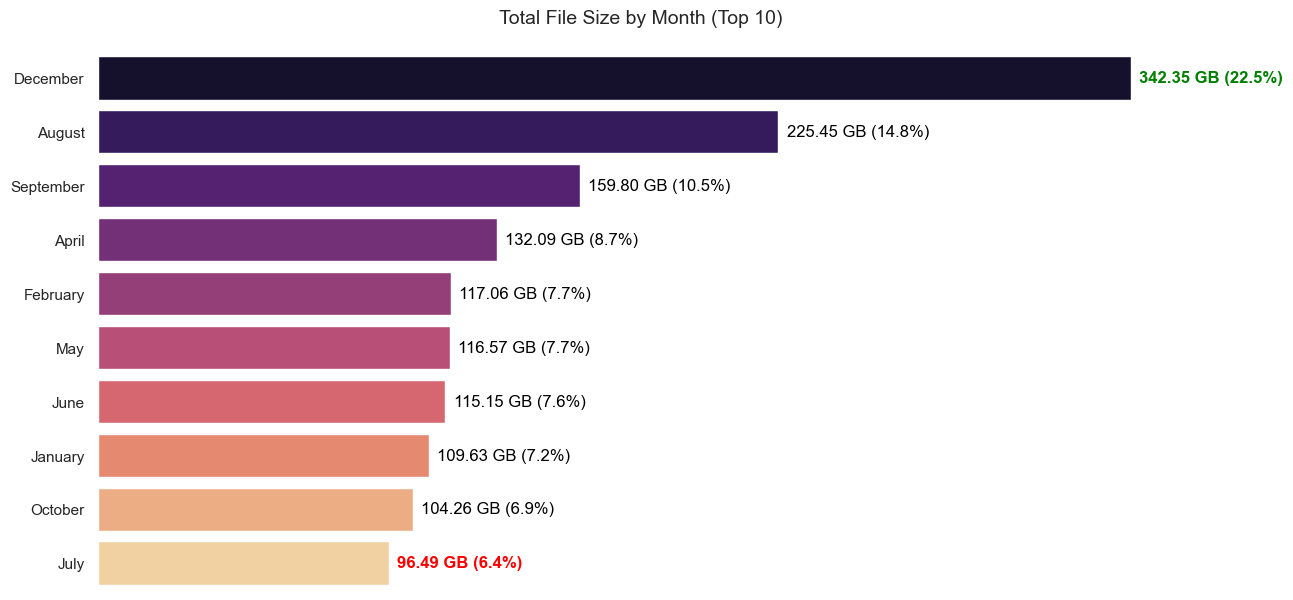

In [191]:
top_n = get_top_n(df_clean, "month_name")

plot_sum(
    df=df_clean,
    column="month_name",
    top_n=top_n,
    title=f"Total File Size by Month (Top {top_n})",
)

In [192]:
df_clean.to_csv(
    FILES_CLEAN_ENGINEERED_CSV,
    sep=";",
    index=False,
)

## 5. Share

### Key Insights
- Major distributions and dominant variables identified
- Correlations highlight potential relationships
- Data quality issues documented and scoped

Insights are presented in a way that can be understood by both technical and non-technical stakeholders.

## 6. Act

### Recommendations
- Improve data completeness in high-missing columns
- Standardize data types at data collection stage
- Conduct deeper analysis on key relationships

### Next Steps
- Segmentation or cohort analysis
- Time-based trend analysis
- Optional predictive modeling if objectives expand